In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np

In [2]:
# we use the mnist digits to demonstrate image classifaction using a convolutional neural network
# use the supplied utility to load MNIST data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
len(mnist.train.images)

55000

In [4]:
len(mnist.test.images)

10000

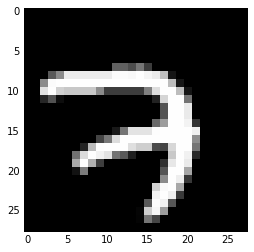

In [6]:
from skimage import io
io.imshow(np.reshape(mnist.train.images[0],(28,28)))

In [7]:
mnist.train.labels[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

In [35]:
def weight_variable(dimensions,stddev):
  return tf.Variable(tf.truncated_normal(dimensions, stddev=stddev))

def bias_variable(dimensions,constant):
  return tf.Variable(tf.constant(constant, shape=dimensions))

def two_dimensional_convolutional_layer(x, W, strides, padding):
  return tf.nn.conv2d(x, W, strides=strides, padding=padding)

def max_pooling(x,strides,ksize,padding):
  return tf.nn.max_pool(x, ksize=ksize,strides=strides, padding=padding)

def generate_network(weight_variables,\
                      bias_variables,\
                      relu_layers,\
                      pooling_layers,\
                      fully_connected_layers,\
                      inputs,\
                      conv_strides,\
                      pool_stries,\
                      ksize,\
                      output_channels,\
                      conv_field_sizes,\
                      conv_field_depths,\
                      sd_weights\
                      ,bias_mean,\
                      padding,\
                      conv_layers,\
                      fc_layers,\
                      fc_shape,\
                      keep_prob,\
                      class_num,\
                      dropouts):
    
    # add convolutional layers
    for k in range(conv_layers):
        weight_variables.append(weight_variable([conv_field_sizes[k], conv_field_sizes[k], conv_field_depths[k],\
                                                 output_channels[k]],sd_weights))
        bias_variables.append(bias_variable([output_channels[k]],bias_mean))
        relu_layers.append(tf.nn.relu(two_dimensional_convolutional_layer(inputs[k],weight_variables[k],\
                                                                          conv_strides,padding) + bias_variables[k]))
        pooling_layers.append(max_pooling(relu_layers[k],pool_strides,ksize,padding))
        inputs.append(pooling_layers[k])
        
    # finally, add fully connected layers at end with dropout
    for r in range(fc_layers):
        weight_variables.append(weight_variable(fc_shape,sd_weights))
        bias_variables.append(bias_variable([fc_shape[1]],bias_mean))
        pooling_layers.append(tf.reshape(pooling_layers[-1],[-1,fc_shape[0]]))
        fully_connected_layers.append(tf.nn.relu(tf.matmul(pooling_layers[-1], weight_variables[-1]) + bias_variables[-1]))
        dropouts.append(tf.nn.dropout(fully_connected_layers[-1], keep_prob))
    
    # output layer
    weight_variables.append(weight_variable([fc_shape[1],class_num],sd_weights))
    bias_variables.append(bias_variable([class_num],bias_mean))
    return tf.nn.softmax(tf.matmul(dropouts[-1],weight_variables[-1])+bias_variables[-1])

In [53]:
X = tf.placeholder("float", shape=[None, 784])
observed = tf.placeholder("float", shape=[None, 10])
images = tf.reshape(X, [-1,28,28,1])

# shape variables
sd_weights = 0.1
bias_mean = 0.1
padding = 'SAME'
conv_strides = [1,1,1,1]
pool_strides = [1,2,2,1]
ksize = [1,2,2,1]
output_channels = [32,64]
conv_field_sizes = [5,5]
conv_field_depths = [1,32]
fc_shape = [7*7*64,1024]
keep_prob = tf.placeholder("float")
class_num = 10
conv_layers = 2
fc_layers = 1

# layers variables
weight_variables = []
bias_variables = []
relu_layers = []
pooling_layers = []
inputs = [images]
fully_connected_layers = []
dropouts = []

prediction = generate_network(weight_variables,\
                      bias_variables,\
                      relu_layers,\
                      pooling_layers,\
                      fully_connected_layers,\
                      inputs,\
                      conv_strides,\
                      pool_strides,\
                      ksize,\
                      output_channels,\
                      conv_field_sizes,\
                      conv_field_depths,\
                      sd_weights\
                      ,bias_mean,\
                      padding,\
                      conv_layers,\
                      fc_layers,\
                      fc_shape,\
                      keep_prob,\
                      class_num,\
                      dropouts)

In [54]:
my_session = tf.InteractiveSession()
squared_error = tf.reduce_sum(tf.pow(tf.reduce_sum(tf.sub(observed,prediction)),[2]))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(squared_error)
correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(observed,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
my_session.run(tf.initialize_all_variables())

for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        X: batch[0], observed: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={X: batch[0], observed: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    X: mnist.test.images, observed: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.04
step 100, training accuracy 0.06
step 200, training accuracy 0.1
step 300, training accuracy 0.16
step 400, training accuracy 0.16
step 500, training accuracy 0.1
step 600, training accuracy 0.1
step 700, training accuracy 0.12
step 800, training accuracy 0.16
step 900, training accuracy 0.06
step 1000, training accuracy 0.14
step 1100, training accuracy 0.06
step 1200, training accuracy 0.14
step 1300, training accuracy 0.1
step 1400, training accuracy 0.08
step 1500, training accuracy 0.18
step 1600, training accuracy 0.1
step 1700, training accuracy 0.18
step 1800, training accuracy 0.06
step 1900, training accuracy 0.08
step 2000, training accuracy 0.16
step 2100, training accuracy 0.24
step 2200, training accuracy 0.1
step 2300, training accuracy 0.18
step 2400, training accuracy 0.12
step 2500, training accuracy 0.06
step 2600, training accuracy 0.1
step 2700, training accuracy 0.08
step 2800, training accuracy 0.18
step 2900, training accuracy 0.1


KeyboardInterrupt: 